In [1]:
import os
import numpy as np
import glob
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, ConvLSTM2D, BatchNormalization, Conv2D, Conv3D,
    MaxPooling2D, MaxPooling3D, TimeDistributed, Flatten, Dense, Dropout, 
    Conv2DTranspose, Concatenate, ZeroPadding2D, Cropping2D, Activation
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from kerastuner import HyperParameters
from kerastuner.tuners import BayesianOptimization


C:\Users\Ngoc Duy\AppData\Local\Temp\ipykernel_20872\1257388833.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


In [19]:
# Hàm đọc dữ liệu
def read_tif_files(base_dir):
    """ 
    Duyệt qua tất cả các file .tif trong cấu trúc: 
    base_dir/yyyy/mm/dd/*.tif và trả về một dictionary với key là ngày (YYYY-MM-DD) 
    và value là danh sách các file chứa dữ liệu và metadata. 
    """
    pattern = os.path.join(base_dir, '*', '*', '*', '*.tif')
    file_list = glob.glob(pattern)
    file_list.sort()
    print(f"Tìm được {len(file_list)} file trong thư mục {base_dir}")
    
    data_dict = {}
    for file_path in file_list:
        parts = file_path.split(os.sep)
        year, month, day = parts[-4], parts[-3], parts[-2]
        date_str = f"{year}-{month}-{day}"
        
        try:
            with rasterio.open(file_path) as src:
                data = src.read(1)
                meta = src.meta
        except Exception as e:
            print(f"Lỗi đọc file {file_path}: {e}")
            continue
            
        data_dict.setdefault(date_str, []).append({
            'file': file_path,
            'data': data,
            'meta': meta
        })
    
    return data_dict

def preprocess_data(data_dict, fill_method='mean'):
    """
    Tiền xử lý dữ liệu, xử lý giá trị NaN và chuẩn hóa dữ liệu
    
    Args:
        data_dict: Dictionary chứa dữ liệu
        fill_method: Phương pháp điền giá trị thiếu ('mean', 'median', 'zero')
    
    Returns:
        Dictionary đã được xử lý
    """
    processed_dict = {}
    
    for date, data_list in data_dict.items():
        processed_dict[date] = []
        
        for item in data_list:
            data = item['data']
            
            # Xác định các giá trị NaN hoặc giá trị khuyết
            invalid_mask = ~np.isfinite(data) | (data < -9000)  # Giả sử -9999 là giá trị fill value
            
            # Điền giá trị thiếu
            if fill_method == 'mean' and not np.all(invalid_mask):
                fill_value = np.nanmean(data[~invalid_mask])
            elif fill_method == 'median' and not np.all(invalid_mask):
                fill_value = np.nanmedian(data[~invalid_mask])
            else:
                fill_value = 0
                
            data_filled = data.copy()
            data_filled[invalid_mask] = fill_value
            
            processed_item = {
                'file': item['file'],
                'data': data_filled,
                'meta': item['meta']
            }
            
            processed_dict[date].append(processed_item)
    
    return processed_dict

def align_data_by_dates(radar_data, era5_data):
    """
    Sắp xếp và căn chỉnh dữ liệu theo ngày tháng.
    
    Returns:
        Các array chứa dữ liệu đã được căn chỉnh theo thời gian
    """
    common_dates = set(radar_data.keys())
    
    # Tìm các ngày có đầy đủ dữ liệu trong cả 2 nguồn
    for var in era5_data:
        common_dates &= set(era5_data[var].keys())
    
    common_dates = sorted(list(common_dates))
    print(f"Tìm thấy {len(common_dates)} ngày có đầy đủ dữ liệu")
    
    if len(common_dates) == 0:
        raise ValueError("Không tìm thấy ngày nào có đầy đủ dữ liệu từ tất cả các nguồn")
    
    # Khởi tạo danh sách lưu trữ
    aligned_radar = []
    aligned_era5 = {var: [] for var in era5_data}
    
    # Sắp xếp dữ liệu theo ngày
    for date in common_dates:
        # Thêm dữ liệu radar
        for item in radar_data[date]:
            aligned_radar.append({
                'date': date,
                'data': item['data'],
                'meta': item['meta']
            })
        
        # Thêm dữ liệu ERA5
        for var in era5_data:
            for item in era5_data[var][date]:
                aligned_era5[var].append({
                    'date': date,
                    'data': item['data'],
                    'meta': item['meta']
                })
    
    return aligned_radar, aligned_era5, common_dates

def normalize_data(data_list):
    """
    Chuẩn hóa dữ liệu về khoảng [0, 1]
    """
    # Tách các mảng dữ liệu
    arrays = [item['data'] for item in data_list]
    
    # Tìm giá trị min và max
    global_min = min(np.min(arr) for arr in arrays)
    global_max = max(np.max(arr) for arr in arrays)
    
    # Chuẩn hóa
    normalized_list = []
    for item in data_list:
        normalized_item = item.copy()
        normalized_item['data'] = (item['data'] - global_min) / (global_max - global_min)
        normalized_list.append(normalized_item)
    
    normalization_params = {
        'min': global_min,
        'max': global_max
    }
    
    return normalized_list, normalization_params


def build_multihorizon_convlstm_model(input_shape, n_horizons):
    """
    Xây dựng mô hình Conv-LSTM dự báo đa-bước
    Args:
        input_shape: tuple, (timesteps, rows, cols, features)
        n_horizons: int, số bước dự báo cần xuất ra
    Returns:
        model: Keras Sequential model với đầu ra shape (rows, cols, n_horizons)
    """
    model = Sequential()
    # ConvLSTM layer 1
    model.add(ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu',
        recurrent_dropout=0.2,
        input_shape=input_shape
    ))
    model.add(BatchNormalization())

    # ConvLSTM layer 2
    model.add(ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        activation='relu',
        recurrent_dropout=0.2
    ))
    model.add(BatchNormalization())

    # ConvLSTM layer 3
    model.add(ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False,
        activation='relu',
        recurrent_dropout=0.2
    ))
    model.add(BatchNormalization())

    # Conv2D output layer với n_horizons filters
    model.add(Conv2D(
        filters=n_horizons,
        kernel_size=(3, 3),
        padding='same',
        activation='linear'
    ))

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    return model

def bayesian_model_builder(hp):
    # Search space
    filters1 = hp.Int('filters1', min_value=32, max_value=128, step=32)
    filters2 = hp.Int('filters2', min_value=16, max_value=64, step=16)
    kernel = hp.Choice('kernel_size', values=[3, 5])
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model = Sequential()
    model.add(ConvLSTM2D(
        filters=filters1,
        kernel_size=(kernel, kernel),
        padding='same',
        return_sequences=True,
        activation='relu',
        recurrent_dropout=dropout,
        input_shape=input_shape  # sử dụng biến toàn cục input_shape
    ))
    model.add(BatchNormalization())

    model.add(ConvLSTM2D(
        filters=filters2,
        kernel_size=(kernel, kernel),
        padding='same',
        return_sequences=False,
        activation='relu',
        recurrent_dropout=dropout
    ))
    model.add(BatchNormalization())

    model.add(Conv2D(
        filters=n_horizons,  # sử dụng biến toàn cục n_horizons
        kernel_size=(3, 3),
        padding='same',
        activation='linear'
    ))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model

from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,
    ZeroPadding2D, Cropping2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_unet_padded(input_shape, n_outputs):
    H, W, C = input_shape
    pad_h = (16 - (H % 16)) % 16
    pad_w = (16 - (W % 16)) % 16

    # 1) Input + padding
    inputs = Input(shape=input_shape)
    x = inputs
    if pad_h or pad_w:
        x = ZeroPadding2D(padding=((0,pad_h),(0,pad_w)))(x)

    # 2) Contracting path
    c1 = Conv2D(64, 3, activation='relu', padding='same')(x)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D()(c4)

    # 3) Bottleneck
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # 4) Expansive path
    u6 = Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)

    # 5) Output + crop về kích thước gốc
    outputs = Conv2D(n_outputs, 1, activation='linear', padding='same')(c9)
    if pad_h or pad_w:
        outputs = Cropping2D(cropping=((0,pad_h),(0,pad_w)))(outputs)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    return model

def build_unet_multi_horizon_bo(hp):
    H, W, C = input_shape    # input_shape = (H, W, seq_length*C_total)
    pad_h = (16 - (H % 16)) % 16
    pad_w = (16 - (W % 16)) % 16

    # hyper-parameters để tune
    base_filters = hp.Int("filters",    16, 64, step=16, default=32)
    depth        = hp.Int("depth",       2, 4,  step=1,  default=3)
    dropout_rate = hp.Float("dropout",    0.0, 0.5, step=0.1, default=0.0)
    lr           = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)

    inputs = Input(shape=input_shape)
    x = inputs
    if pad_h or pad_w:
        x = ZeroPadding2D(padding=((0,pad_h),(0,pad_w)))(x)

    # contracting path
    skips = []
    for d in range(depth):
        f = base_filters * (2**d)
        x = Conv2D(f, 3, activation="relu", padding="same")(x)
        x = Conv2D(f, 3, activation="relu", padding="same")(x)
        skips.append(x)
        x = MaxPooling2D()(x)

    # bottleneck
    f = base_filters * (2**depth)
    x = Conv2D(f, 3, activation="relu", padding="same")(x)
    x = Conv2D(f, 3, activation="relu", padding="same")(x)

    # expansive path
    for d in reversed(range(depth)):
        f = base_filters * (2**d)
        x = Conv2DTranspose(f, 2, strides=2, padding="same")(x)
        x = concatenate([x, skips[d]])
        x = Conv2D(f, 3, activation="relu", padding="same")(x)
        x = Conv2D(f, 3, activation="relu", padding="same")(x)
        if dropout_rate > 0:
            x = tf.keras.layers.Dropout(dropout_rate)(x)

    # output + crop
    outputs = Conv2D(n_outputs, 1, activation="linear", padding="same")(x)
    if pad_h or pad_w:
        outputs = Cropping2D(cropping=((0,pad_h),(0,pad_w)))(outputs)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return model

def create_multivariate_sequences_multi(radar_data, era5_data, common_dates,
                                        seq_length=6, horizon_list=[1,2,3,4,5,6]):
    """
    Tạo chuỗi dữ liệu đa biến kết hợp radar + ERA5 cho nhiều horizon cùng lúc
    Args:
        radar_data: list of {'data': 2D array, ...}
        era5_data: dict[var] -> list of {'data': 2D array, ...}
        common_dates: list of date strings
        seq_length: số bước time-step vào
        horizon_list: danh sách các bước dự báo (ví dụ [1,2,3,4,5,6])
    Returns:
        X: (n_samples, seq_length, H, W, C)
        y: (n_samples, H, W, len(horizon_list))
        radar_params: dict với min/max để đổi ngược chuẩn hóa
    """
    # 1) Chuẩn hóa radar và ERA5
    norm_radar, radar_params = normalize_data(radar_data)
    norm_era5 = {}
    for var, data_list in era5_data.items():
        norm_era5[var], _ = normalize_data(data_list)

    # 2) Xây list frame đa kênh theo common_dates
    frames = []
    for i in range(len(common_dates)):
        channels = [norm_radar[i]['data'][..., None]]
        for var in norm_era5:
            channels.append(norm_era5[var][i]['data'][..., None])
        frame = np.concatenate(channels, axis=-1)  # (H, W, C_total)
        frames.append(frame)
    multi_array = np.stack(frames, axis=0)  # (T, H, W, C_total)

    # 3) Tạo X và y_multi
    X_list, y_list = [], []
    max_h = max(horizon_list)
    for i in range(len(multi_array) - seq_length - max_h + 1):
        # input sequence
        X_list.append(multi_array[i:i+seq_length])
        # tạo các channel đầu ra cho từng horizon
        rain_channels = []
        for h in horizon_list:
            rain = multi_array[i + seq_length + h - 1, ..., 0]  # channel radar (mưa)
            rain_channels.append(rain)
        # stack thành (H, W, len(horizon_list))
        y_list.append(np.stack(rain_channels, axis=-1))

    X = np.array(X_list)
    y = np.array(y_list)
    return X, y, radar_params



def train_multi_horizon_models(X, y, radar_params, seq_length=6, 
                            max_horizon=6, val_split=0.2, epochs=5, batch_size=8):
    """
    Huấn luyện nhiều mô hình để dự báo từ 1 đến max_horizon giờ tới
    """
    models = {}
    histories = {}
    
    # Chia tập huấn luyện và kiểm định ngay từ đầu
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_split, random_state=42, shuffle=False)
    
    for horizon in range(1, max_horizon + 1):
        print(f"\n=== Huấn luyện mô hình dự báo {horizon} giờ tới ===")
        
        # Xây dựng mô hình
        input_shape = X_train.shape[1:]  # (timesteps, rows, cols, features)
        output_shape = y_train.shape[1:] # (rows, cols, 1)
        
        model = build_convlstm_model(input_shape, output_shape)
        
        # Callbacks
        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=5),
            ModelCheckpoint(f"model_horizon_{horizon}.h5", save_best_only=True)
        ]
        
        # Huấn luyện mô hình
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=callbacks
        )
        
        # Lưu mô hình và lịch sử huấn luyện
        models[horizon] = model
        histories[horizon] = history.history
        
        # Đánh giá mô hình
        val_loss, val_mae = model.evaluate(X_val, y_val)
        print(f"Mô hình dự báo {horizon}h - Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
    
    return models, histories, radar_params

def make_predictions(model, input_data, radar_params):
    """
    Thực hiện dự báo đa-bước bằng 1 model duy nhất
    Args:
        model: Keras model xuất ra n_horizons kênh
        input_data: numpy array (N, seq_length, H, W, C)
        radar_params: dict chứa 'min' và 'max' để đổi ngược chuẩn hóa
    Returns:
        preds: numpy array (N, H, W, n_horizons)
    """
    # Dự báo
    preds = model.predict(input_data)
    # Đổi ngược chuẩn hóa về giá trị gốc
    min_val, max_val = radar_params['min'], radar_params['max']
    preds = preds * (max_val - min_val) + min_val
    # Loại giá trị âm
    preds[preds < 0] = 0
    return preds

def visualize_predictions(original, preds, horizons, timestep=0):
    """
    Hiển thị kết quả thực tế và dự báo đa-bước
    Args:
        original: numpy array (N, H, W, n_horizons) giá trị thực
        preds: numpy array (N, H, W, n_horizons) dự báo
        horizons: list các horizon tương ứng
        timestep: chỉ số mẫu cần hiển thị
    """
    n = len(horizons)
    fig, axes = plt.subplots(1, n+1, figsize=(4*(n+1), 4))
    # Thực tế (chọn kênh horizon=1)
    im = axes[0].imshow(original[timestep, ..., 0], cmap='Blues')
    axes[0].set_title('Thực tế 1h')
    plt.colorbar(im, ax=axes[0])
    # Dự báo từng bước
    for i, h in enumerate(horizons):
        im = axes[i+1].imshow(preds[timestep, ..., i], cmap='Blues')
        axes[i+1].set_title(f'Dự báo {h}h')
        plt.colorbar(im, ax=axes[i+1])
    plt.tight_layout()
    plt.show()


In [3]:
# Đọc dữ liệu ERA5 và Radar
era5_base_dir = os.path.join("DATA_SV", "ERA5")
era5_vars = [
    'V850', 'V250', 'U850', 'U250', 'TCWV', 'TCW', 'TCLW',
    'SSHF', 'SLOR', 'SLHF', 'R850', 'R500', 'R250',
    'PEV', 'KX', 'ISOR', 'IE', 'EWSS', 'CIN', 'CAPE'
]
era5_data = {}
for var in era5_vars:
    var_dir = os.path.join(era5_base_dir, var)
    print(f"Đọc ERA5 cho biến {var}")
    era5_data[var] = read_tif_files(var_dir)

radar_dir = os.path.join("DATA_SV", "Precipitation", "Radar")
print("Đọc radar precipitation")
radar_data = read_tif_files(radar_dir)

Đọc ERA5 cho biến V850
Tìm được 2928 file trong thư mục DATA_SV\ERA5\V850
Đọc ERA5 cho biến V250
Tìm được 2928 file trong thư mục DATA_SV\ERA5\V250
Đọc ERA5 cho biến U850
Tìm được 2928 file trong thư mục DATA_SV\ERA5\U850
Đọc ERA5 cho biến U250
Tìm được 2928 file trong thư mục DATA_SV\ERA5\U250
Đọc ERA5 cho biến TCWV
Tìm được 2928 file trong thư mục DATA_SV\ERA5\TCWV
Đọc ERA5 cho biến TCW
Tìm được 2928 file trong thư mục DATA_SV\ERA5\TCW
Đọc ERA5 cho biến TCLW
Tìm được 2928 file trong thư mục DATA_SV\ERA5\TCLW
Đọc ERA5 cho biến SSHF
Tìm được 2928 file trong thư mục DATA_SV\ERA5\SSHF
Đọc ERA5 cho biến SLOR
Tìm được 2928 file trong thư mục DATA_SV\ERA5\SLOR
Đọc ERA5 cho biến SLHF
Tìm được 2928 file trong thư mục DATA_SV\ERA5\SLHF
Đọc ERA5 cho biến R850
Tìm được 2928 file trong thư mục DATA_SV\ERA5\R850
Đọc ERA5 cho biến R500
Tìm được 2928 file trong thư mục DATA_SV\ERA5\R500
Đọc ERA5 cho biến R250
Tìm được 2928 file trong thư mục DATA_SV\ERA5\R250
Đọc ERA5 cho biến PEV
Tìm được 2928 file

In [4]:
# Tiền xử lí dữ liệu
print("Tiền xử lý radar")
processed_radar = preprocess_data(radar_data, fill_method='zero')

print("Tiền xử lý ERA5")
processed_era5 = {
    var: preprocess_data(era5_data[var], fill_method='mean')
    for var in era5_data
}

# Căn chỉnh theo ngày
print("Căn chỉnh dữ liệu theo thời gian")
aligned_radar, aligned_era5, common_dates = align_data_by_dates(
    processed_radar, processed_era5
)

# Tạo dataset đa biến + đa-horizon
seq_length = 6
horizons = [1, 2, 3, 4, 5, 6]
print(f"Tạo X,y cho horizons={horizons}")
X, y, radar_params = create_multivariate_sequences_multi(
    aligned_radar, aligned_era5, common_dates,
    seq_length=seq_length, horizon_list=horizons
)
print("X shape:", X.shape, " y shape:", y.shape)

# Chia train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

Tiền xử lý radar
Tiền xử lý ERA5
Căn chỉnh dữ liệu theo thời gian
Tìm thấy 110 ngày có đầy đủ dữ liệu
Tạo X,y cho horizons=[1, 2, 3, 4, 5, 6]
X shape: (99, 6, 90, 250, 21)  y shape: (99, 90, 250, 6)


In [5]:
# X.shape = (N, seq_length, H, W, C_total)
# y.shape = (N, H, W, n_horizons)

# Lấy shape
N, seq_length, H, W, C_total = X_train.shape
_, _, _, n_horizons = y_train.shape

# Đưa chiều time và feature vào chung thành channels
X_train_u = X_train.transpose(0,2,3,1,4).reshape(N, H, W, seq_length*C_total)
X_val_u   = X_val.transpose(0,2,3,1,4).reshape(X_val.shape[0], H, W, seq_length*C_total)


In [16]:
# Khởi tạo U-Net
unet_input_shape = (H, W, seq_length*C_total)
model = build_unet_padded(unet_input_shape, n_outputs=n_horizons)

# Callbacks (giữ nguyên)
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=7, factor=0.5),
    ModelCheckpoint("unet_multi_horizon.h5", save_best_only=True)
]

# Train trên dữ liệu đã reshape
history = model.fit(
    X_train_u, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val_u, y_val),
    callbacks=callbacks
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0159 - mae: 0.0920

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0153 - mae: 0.0894 - val_loss: 5.9836e-04 - val_mae: 0.0190 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.3257e-04 - mae: 0.0160

10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 4.2220e-04 - mae: 0.0158 - val_loss: 9.3284e-05 - val_mae: 0.0071 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.8463e-05 - mae: 0.0068

10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 8.7333e-05 - mae: 0.0067 - val_loss: 4.9782e-05 - val_mae: 0.0051 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.5929e-05 - mae: 0.0048

10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 4.5452e-05 - mae: 0.0047 - val_loss: 2.3443e-05 - val_mae: 0.0034 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.8408e-05 - mae: 0.0036

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 2.8300e-05 - mae: 0.0036 - val_loss: 1.5997e-05 - val_mae: 0.0027 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.0338e-05 - mae: 0.0028

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 2.0290e-05 - mae: 0.0028 - val_loss: 1.2489e-05 - val_mae: 0.0024 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.6846e-05 - mae: 0.0025

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.6817e-05 - mae: 0.0025 - val_loss: 9.6741e-06 - val_mae: 0.0021 - learning_rate: 0.0010
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.5551e-05 - mae: 0.0023

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.5441e-05 - mae: 0.0023 - val_loss: 8.3153e-06 - val_mae: 0.0020 - learning_rate: 0.0010
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2463e-05 - mae: 0.0022

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.2504e-05 - mae: 0.0022 - val_loss: 7.5966e-06 - val_mae: 0.0019 - learning_rate: 0.0010
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2075e-05 - mae: 0.0020

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.2060e-05 - mae: 0.0020 - val_loss: 7.0005e-06 - val_mae: 0.0019 - learning_rate: 5.0000e-04
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0791e-05 - mae: 0.0020

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.0845e-05 - mae: 0.0020 - val_loss: 6.5847e-06 - val_mae: 0.0018 - learning_rate: 5.0000e-04
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0703e-05 - mae: 0.0019

10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 1.0731e-05 - mae: 0.0019 - val_loss: 6.3436e-06 - val_mae: 0.0018 - learning_rate: 5.0000e-04
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0713e-05 - mae: 0.0019

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.0704e-05 - mae: 0.0019 - val_loss: 5.9049e-06 - val_mae: 0.0017 - learning_rate: 5.0000e-04
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.1433e-05 - mae: 0.0019

10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 1.1324e-05 - mae: 0.0019 - val_loss: 5.6200e-06 - val_mae: 0.0017 - learning_rate: 5.0000e-04
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0655e-05 - mae: 0.0018

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.0591e-05 - mae: 0.0018 - val_loss: 5.0247e-06 - val_mae: 0.0016 - learning_rate: 5.0000e-04
Epoch 16/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 9.7437e-06 - mae: 0.0018

10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 9.7300e-06 - mae: 0.0018 - val_loss: 4.6977e-06 - val_mae: 0.0016 - learning_rate: 5.0000e-04
Epoch 17/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 9.1026e-06 - mae: 0.0017 - val_loss: 4.7668e-06 - val_mae: 0.0016 - learning_rate: 2.5000e-04
Epoch 18/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 9.6818e-06 - mae: 0.0017

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 9.6284e-06 - mae: 0.0017 - val_loss: 4.6922e-06 - val_mae: 0.0016 - learning_rate: 2.5000e-04
Epoch 19/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.3740e-06 - mae: 0.0017

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 8.4289e-06 - mae: 0.0017 - val_loss: 4.3646e-06 - val_mae: 0.0015 - learning_rate: 2.5000e-04
Epoch 20/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.9002e-06 - mae: 0.0016

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 8.8932e-06 - mae: 0.0016 - val_loss: 4.2913e-06 - val_mae: 0.0015 - learning_rate: 2.5000e-04
Epoch 21/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 9.3074e-06 - mae: 0.0016 - val_loss: 4.3753e-06 - val_mae: 0.0016 - learning_rate: 2.5000e-04
Epoch 22/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.3929e-06 - mae: 0.0016

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 8.4082e-06 - mae: 0.0016 - val_loss: 4.1092e-06 - val_mae: 0.0015 - learning_rate: 2.5000e-04
Epoch 23/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 9.0018e-06 - mae: 0.0016 - val_loss: 4.1982e-06 - val_mae: 0.0015 - learning_rate: 2.5000e-04
Epoch 24/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.2998e-06 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 8.3075e-06 - mae: 0.0015 - val_loss: 3.8870e-06 - val_mae: 0.0014 - learning_rate: 1.2500e-04
Epoch 25/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 8.0343e-06 - mae: 0.0015 - val_loss: 3.9636e-06 - val_mae: 0.0015 - learning_rate: 1.2500e-04
Epoch 26/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.5947e-06 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 7.6540e-06 - mae: 0.0015 - val_loss: 3.8678e-06 - val_mae: 0.0014 - learning_rate: 1.2500e-04
Epoch 27/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.8376e-06 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 7.8718e-06 - mae: 0.0015 - val_loss: 3.8506e-06 - val_mae: 0.0014 - learning_rate: 1.2500e-04
Epoch 28/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.6300e-06 - mae: 0.0016

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 8.5867e-06 - mae: 0.0015 - val_loss: 3.8012e-06 - val_mae: 0.0014 - learning_rate: 1.2500e-04
Epoch 29/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.4136e-06 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 7.4796e-06 - mae: 0.0015 - val_loss: 3.6777e-06 - val_mae: 0.0014 - learning_rate: 1.2500e-04
Epoch 30/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 7.7880e-06 - mae: 0.0015 - val_loss: 3.7415e-06 - val_mae: 0.0014 - learning_rate: 1.2500e-04
Epoch 31/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.7357e-06 - mae: 0.0015 - val_loss: 3.7118e-06 - val_mae: 0.0014 - learning_rate: 6.2500e-05
Epoch 32/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.7511e-06 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.7745e-06 - mae: 0.0015 - val_loss: 3.6424e-06 - val_mae: 0.0014 - learning_rate: 6.2500e-05
Epoch 33/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.0232e-06 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 8.0198e-06 - mae: 0.0015 - val_loss: 3.6309e-06 - val_mae: 0.0014 - learning_rate: 6.2500e-05
Epoch 34/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 8.0431e-06 - mae: 0.0015 - val_loss: 3.6632e-06 - val_mae: 0.0014 - learning_rate: 6.2500e-05
Epoch 35/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.1041e-06 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.1811e-06 - mae: 0.0015 - val_loss: 3.5535e-06 - val_mae: 0.0014 - learning_rate: 6.2500e-05
Epoch 36/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 8.2693e-06 - mae: 0.0015 - val_loss: 3.6767e-06 - val_mae: 0.0014 - learning_rate: 6.2500e-05
Epoch 37/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 6.9578e-06 - mae: 0.0015 - val_loss: 3.5648e-06 - val_mae: 0.0014 - learning_rate: 6.2500e-05
Epoch 38/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.1201e-06 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 8.0987e-06 - mae: 0.0015 - val_loss: 3.5275e-06 - val_mae: 0.0014 - learning_rate: 3.1250e-05
Epoch 39/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.6201e-06 - mae: 0.0015 - val_loss: 3.5459e-06 - val_mae: 0.0014 - learning_rate: 3.1250e-05
Epoch 40/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 8.4541e-06 - mae: 0.0015 - val_loss: 3.5375e-06 - val_mae: 0.0014 - learning_rate: 3.1250e-05
Epoch 41/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.9477e-06 - mae: 0.0015 - val_loss: 3.5375e-06 - val_mae: 0.0014 - learning_rate: 3.1250e-05
Epoch 42/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 6.8391e-06 - mae: 0.0014 - val_loss: 3.5351e-06 - val_mae: 0.0014 - learning_rate: 3.1250e-05
Epoch 43/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.7179e-06 - mae: 0.0014

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.7279e-06 - mae: 0.0014 - val_loss: 3.4802e-06 - val_mae: 0.0014 - learning_rate: 3.1250e-05
Epoch 44/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 8.2929e-06 - mae: 0.0015 - val_loss: 3.5000e-06 - val_mae: 0.0014 - learning_rate: 3.1250e-05
Epoch 45/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.5516e-06 - mae: 0.0014 - val_loss: 3.5043e-06 - val_mae: 0.0014 - learning_rate: 1.5625e-05
Epoch 46/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.5148e-06 - mae: 0.0015 - val_loss: 3.4946e-06 - val_mae: 0.0014 - learning_rate: 1.5625e-05
Epoch 47/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.5785e-06 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 8.5075e-06 - mae: 0.0015 - val_loss: 3.4757e-06 - val_mae: 0.0014 - learning_rate: 1.5625e-05
Epoch 48/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 8.8340e-06 - mae: 0.0015 - val_loss: 3.4793e-06 - val_mae: 0.0014 - learning_rate: 1.5625e-05
Epoch 49/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.3355e-06 - mae: 0.0014

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.3765e-06 - mae: 0.0014 - val_loss: 3.4657e-06 - val_mae: 0.0014 - learning_rate: 1.5625e-05
Epoch 50/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.5012e-06 - mae: 0.0015 - val_loss: 3.4665e-06 - val_mae: 0.0014 - learning_rate: 1.5625e-05


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


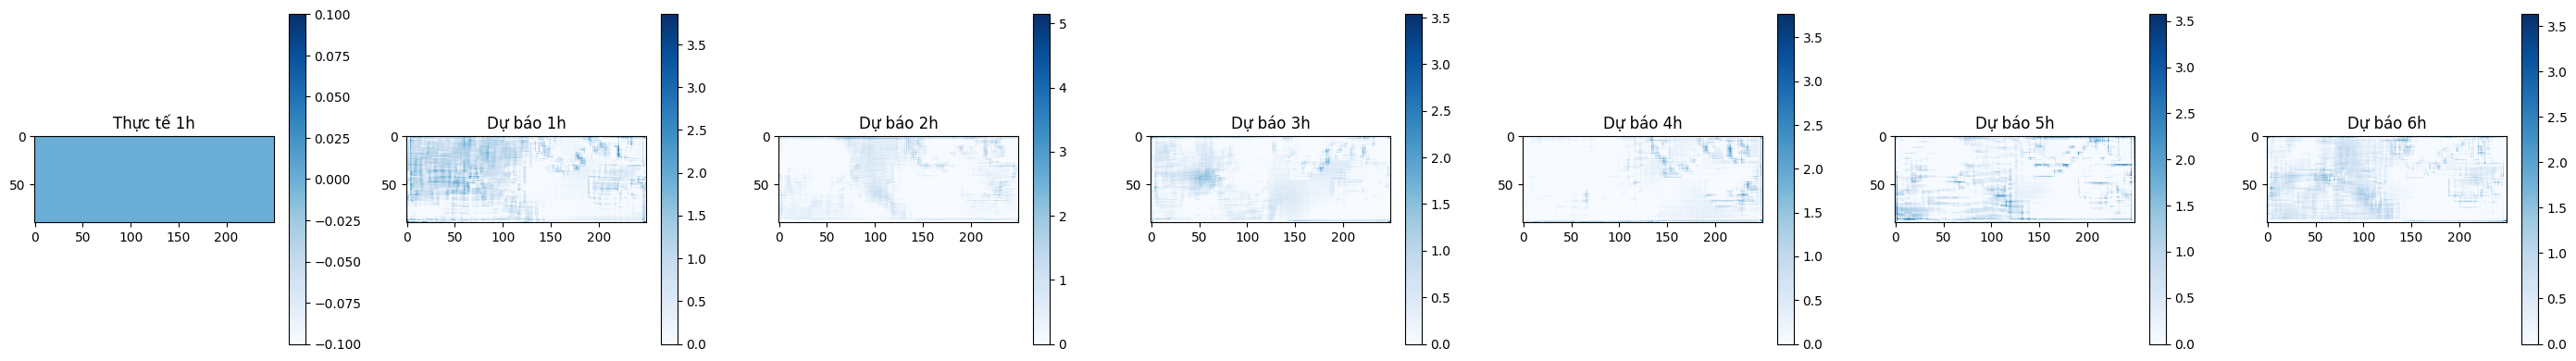

Hoàn thành dự báo với U-Net!


In [20]:
# --- Dự báo và hiển thị với U-Net ---
test_sample_u = X_val_u[-1:]  # chọn mẫu cuối sau reshape
preds = make_predictions(model, test_sample_u, radar_params)

# visualize_predictions vẫn dùng y_val gốc và danh sách horizons
visualize_predictions(y_val, preds, horizons=horizons, timestep=0)

# --- Lưu model U-Net ---
model.save("unet_multi_horizon.h5")
print("Hoàn thành dự báo với U-Net!") 

In [8]:
input_shape = unet_input_shape      # ví dụ (H, W, seq_length*C_total)
n_outputs   = n_horizons            # số horizon
tuner = BayesianOptimization(
    hypermodel=build_unet_multi_horizon_bo,
    objective="val_loss",
    max_trials=5,
    num_initial_points=3,
    directory="unet_bo",
    project_name="rainfall_unet_bo"
)

tuner.search(
    X_train_u, y_train,
    validation_data=(X_val_u, y_val),
    epochs=5,
    batch_size=16,
    callbacks=[ EarlyStopping(patience=5, restore_best_weights=True) ]
)

# 4) Lấy mô hình tốt nhất
best_hp    = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

# 5) Callbacks & fine-tune trên toàn bộ dữ liệu
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=7, factor=0.5),
    ModelCheckpoint("unet_multi_horizon_bo.h5", save_best_only=True)
]

history = best_model.fit(
    X_train_u, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val_u, y_val),
    callbacks=callbacks
)

Trial 5 Complete [00h 00m 23s]
val_loss: 8.957636055129115e-06

Best val_loss So Far: 2.184232016588794e-06
Total elapsed time: 01h 35m 06s
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.0268 - mae: 0.1217

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0256 - mae: 0.1179 - val_loss: 0.0014 - val_mae: 0.0301 - learning_rate: 1.3871e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.0019 - mae: 0.0346

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - loss: 0.0019 - mae: 0.0344 - val_loss: 5.8927e-04 - val_mae: 0.0187 - learning_rate: 1.3871e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 8.4760e-04 - mae: 0.0227

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - loss: 8.3840e-04 - mae: 0.0225 - val_loss: 4.1639e-04 - val_mae: 0.0151 - learning_rate: 1.3871e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 4.1737e-04 - mae: 0.0153

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - loss: 4.1198e-04 - mae: 0.0152 - val_loss: 1.4914e-04 - val_mae: 0.0090 - learning_rate: 1.3871e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 2.3568e-04 - mae: 0.0114

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - loss: 2.3405e-04 - mae: 0.0113 - val_loss: 1.1281e-04 - val_mae: 0.0073 - learning_rate: 1.3871e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 1.5675e-04 - mae: 0.0088

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - loss: 1.5561e-04 - mae: 0.0087 - val_loss: 8.4756e-05 - val_mae: 0.0059 - learning_rate: 1.3871e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 1.0728e-04 - mae: 0.0070

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - loss: 1.0671e-04 - mae: 0.0070 - val_loss: 5.2908e-05 - val_mae: 0.0046 - learning_rate: 1.3871e-04
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 7.7506e-05 - mae: 0.0058

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - loss: 7.7052e-05 - mae: 0.0058 - val_loss: 3.5366e-05 - val_mae: 0.0037 - learning_rate: 1.3871e-04
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 5.6903e-05 - mae: 0.0048

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - loss: 5.6526e-05 - mae: 0.0047 - val_loss: 2.3192e-05 - val_mae: 0.0030 - learning_rate: 1.3871e-04
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 4.0756e-05 - mae: 0.0039

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - loss: 4.0567e-05 - mae: 0.0039 - val_loss: 1.5600e-05 - val_mae: 0.0024 - learning_rate: 1.3871e-04
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 3.0646e-05 - mae: 0.0033

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step - loss: 3.0477e-05 - mae: 0.0032 - val_loss: 1.0167e-05 - val_mae: 0.0019 - learning_rate: 1.3871e-04
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 2.2841e-05 - mae: 0.0027

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 376ms/step - loss: 2.2751e-05 - mae: 0.0027 - val_loss: 6.9534e-06 - val_mae: 0.0015 - learning_rate: 1.3871e-04
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 1.7034e-05 - mae: 0.0022

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 379ms/step - loss: 1.6993e-05 - mae: 0.0022 - val_loss: 5.0028e-06 - val_mae: 0.0013 - learning_rate: 1.3871e-04
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 1.4031e-05 - mae: 0.0018

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - loss: 1.3940e-05 - mae: 0.0018 - val_loss: 3.8827e-06 - val_mae: 0.0011 - learning_rate: 1.3871e-04
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 1.0119e-05 - mae: 0.0015

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - loss: 1.0182e-05 - mae: 0.0015 - val_loss: 2.9766e-06 - val_mae: 9.6850e-04 - learning_rate: 1.3871e-04
Epoch 16/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 9.6115e-06 - mae: 0.0013

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - loss: 9.6136e-06 - mae: 0.0013 - val_loss: 2.5581e-06 - val_mae: 9.0828e-04 - learning_rate: 6.9353e-05
Epoch 17/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 8.2797e-06 - mae: 0.0013

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 376ms/step - loss: 8.3429e-06 - mae: 0.0013 - val_loss: 2.2437e-06 - val_mae: 8.5435e-04 - learning_rate: 6.9353e-05
Epoch 18/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 8.4188e-06 - mae: 0.0012

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - loss: 8.4232e-06 - mae: 0.0012 - val_loss: 1.9930e-06 - val_mae: 8.0563e-04 - learning_rate: 6.9353e-05
Epoch 19/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 9.5470e-06 - mae: 0.0011

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - loss: 9.4099e-06 - mae: 0.0011 - val_loss: 1.7821e-06 - val_mae: 7.6130e-04 - learning_rate: 6.9353e-05
Epoch 20/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 1.0171e-05 - mae: 0.0011

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - loss: 9.9404e-06 - mae: 0.0011 - val_loss: 1.6142e-06 - val_mae: 7.2629e-04 - learning_rate: 6.9353e-05
Epoch 21/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 6.4893e-06 - mae: 0.0010

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - loss: 6.5647e-06 - mae: 0.0010 - val_loss: 1.4662e-06 - val_mae: 6.9804e-04 - learning_rate: 6.9353e-05
Epoch 22/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 7.3745e-06 - mae: 9.8198e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - loss: 7.3467e-06 - mae: 9.8110e-04 - val_loss: 1.3439e-06 - val_mae: 6.7136e-04 - learning_rate: 6.9353e-05
Epoch 23/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 6.5206e-06 - mae: 9.4133e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - loss: 6.5522e-06 - mae: 9.4116e-04 - val_loss: 1.2871e-06 - val_mae: 6.5798e-04 - learning_rate: 3.4676e-05
Epoch 24/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 5.9335e-06 - mae: 9.1077e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - loss: 6.0072e-06 - mae: 9.1152e-04 - val_loss: 1.2321e-06 - val_mae: 6.4477e-04 - learning_rate: 3.4676e-05
Epoch 25/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 6.7574e-06 - mae: 9.0411e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - loss: 6.7500e-06 - mae: 9.0419e-04 - val_loss: 1.1802e-06 - val_mae: 6.3186e-04 - learning_rate: 3.4676e-05
Epoch 26/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 6.4440e-06 - mae: 8.8670e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step - loss: 6.4532e-06 - mae: 8.8658e-04 - val_loss: 1.1339e-06 - val_mae: 6.1907e-04 - learning_rate: 3.4676e-05
Epoch 27/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 6.6921e-06 - mae: 8.7274e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - loss: 6.6709e-06 - mae: 8.7226e-04 - val_loss: 1.0887e-06 - val_mae: 6.0655e-04 - learning_rate: 3.4676e-05
Epoch 28/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 5.5970e-06 - mae: 8.4541e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - loss: 5.6679e-06 - mae: 8.4603e-04 - val_loss: 1.0425e-06 - val_mae: 5.9378e-04 - learning_rate: 3.4676e-05
Epoch 29/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 6.7415e-06 - mae: 8.4550e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - loss: 6.7020e-06 - mae: 8.4481e-04 - val_loss: 1.0023e-06 - val_mae: 5.8192e-04 - learning_rate: 3.4676e-05
Epoch 30/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 6.3862e-06 - mae: 8.2531e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - loss: 6.3706e-06 - mae: 8.2506e-04 - val_loss: 9.8096e-07 - val_mae: 5.7579e-04 - learning_rate: 1.7338e-05
Epoch 31/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 6.0450e-06 - mae: 8.1100e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step - loss: 6.0585e-06 - mae: 8.1164e-04 - val_loss: 9.6000e-07 - val_mae: 5.6966e-04 - learning_rate: 1.7338e-05
Epoch 32/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 4.5652e-06 - mae: 7.8380e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step - loss: 4.7108e-06 - mae: 7.8620e-04 - val_loss: 9.4086e-07 - val_mae: 5.6355e-04 - learning_rate: 1.7338e-05
Epoch 33/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 5.5182e-06 - mae: 7.9542e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - loss: 5.5721e-06 - mae: 7.9594e-04 - val_loss: 9.2202e-07 - val_mae: 5.5757e-04 - learning_rate: 1.7338e-05
Epoch 34/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 7.3091e-06 - mae: 8.1968e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - loss: 7.1973e-06 - mae: 8.1731e-04 - val_loss: 9.0201e-07 - val_mae: 5.5165e-04 - learning_rate: 1.7338e-05
Epoch 35/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 6.8771e-06 - mae: 7.9837e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - loss: 6.8014e-06 - mae: 7.9727e-04 - val_loss: 8.8219e-07 - val_mae: 5.4557e-04 - learning_rate: 1.7338e-05
Epoch 36/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 5.2477e-06 - mae: 7.6535e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - loss: 5.3166e-06 - mae: 7.6647e-04 - val_loss: 8.6437e-07 - val_mae: 5.3942e-04 - learning_rate: 1.7338e-05
Epoch 37/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 5.7517e-06 - mae: 7.7097e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - loss: 5.7729e-06 - mae: 7.7106e-04 - val_loss: 8.5492e-07 - val_mae: 5.3639e-04 - learning_rate: 8.6691e-06
Epoch 38/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 6.0015e-06 - mae: 7.6633e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - loss: 5.9973e-06 - mae: 7.6649e-04 - val_loss: 8.4499e-07 - val_mae: 5.3326e-04 - learning_rate: 8.6691e-06
Epoch 39/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 6.4101e-06 - mae: 7.7516e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - loss: 6.3688e-06 - mae: 7.7426e-04 - val_loss: 8.3574e-07 - val_mae: 5.3020e-04 - learning_rate: 8.6691e-06
Epoch 40/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 5.8712e-06 - mae: 7.5880e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 379ms/step - loss: 5.8752e-06 - mae: 7.5882e-04 - val_loss: 8.2687e-07 - val_mae: 5.2714e-04 - learning_rate: 8.6691e-06
Epoch 41/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 5.3955e-06 - mae: 7.4816e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - loss: 5.4423e-06 - mae: 7.4898e-04 - val_loss: 8.1726e-07 - val_mae: 5.2398e-04 - learning_rate: 8.6691e-06
Epoch 42/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 6.0994e-06 - mae: 7.5528e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - loss: 6.0806e-06 - mae: 7.5513e-04 - val_loss: 8.0794e-07 - val_mae: 5.2088e-04 - learning_rate: 8.6691e-06
Epoch 43/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 5.8089e-06 - mae: 7.5157e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 430ms/step - loss: 5.8169e-06 - mae: 7.5147e-04 - val_loss: 7.9869e-07 - val_mae: 5.1767e-04 - learning_rate: 8.6691e-06
Epoch 44/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 5.1392e-06 - mae: 7.3648e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - loss: 5.2052e-06 - mae: 7.3738e-04 - val_loss: 7.9401e-07 - val_mae: 5.1608e-04 - learning_rate: 4.3345e-06
Epoch 45/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - loss: 6.5361e-06 - mae: 7.5143e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - loss: 6.4742e-06 - mae: 7.5074e-04 - val_loss: 7.8933e-07 - val_mae: 5.1450e-04 - learning_rate: 4.3345e-06
Epoch 46/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 6.0788e-06 - mae: 7.4675e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - loss: 6.0585e-06 - mae: 7.4643e-04 - val_loss: 7.8475e-07 - val_mae: 5.1289e-04 - learning_rate: 4.3345e-06
Epoch 47/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 5.1300e-06 - mae: 7.2678e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - loss: 5.1933e-06 - mae: 7.2793e-04 - val_loss: 7.8046e-07 - val_mae: 5.1125e-04 - learning_rate: 4.3345e-06
Epoch 48/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 5.4578e-06 - mae: 7.3088e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - loss: 5.4907e-06 - mae: 7.3145e-04 - val_loss: 7.7568e-07 - val_mae: 5.0963e-04 - learning_rate: 4.3345e-06
Epoch 49/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 5.3180e-06 - mae: 7.2949e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - loss: 5.3617e-06 - mae: 7.2993e-04 - val_loss: 7.7127e-07 - val_mae: 5.0799e-04 - learning_rate: 4.3345e-06
Epoch 50/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 5.5229e-06 - mae: 7.2868e-04

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step - loss: 5.5476e-06 - mae: 7.2902e-04 - val_loss: 7.6659e-07 - val_mae: 5.0632e-04 - learning_rate: 4.3345e-06


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


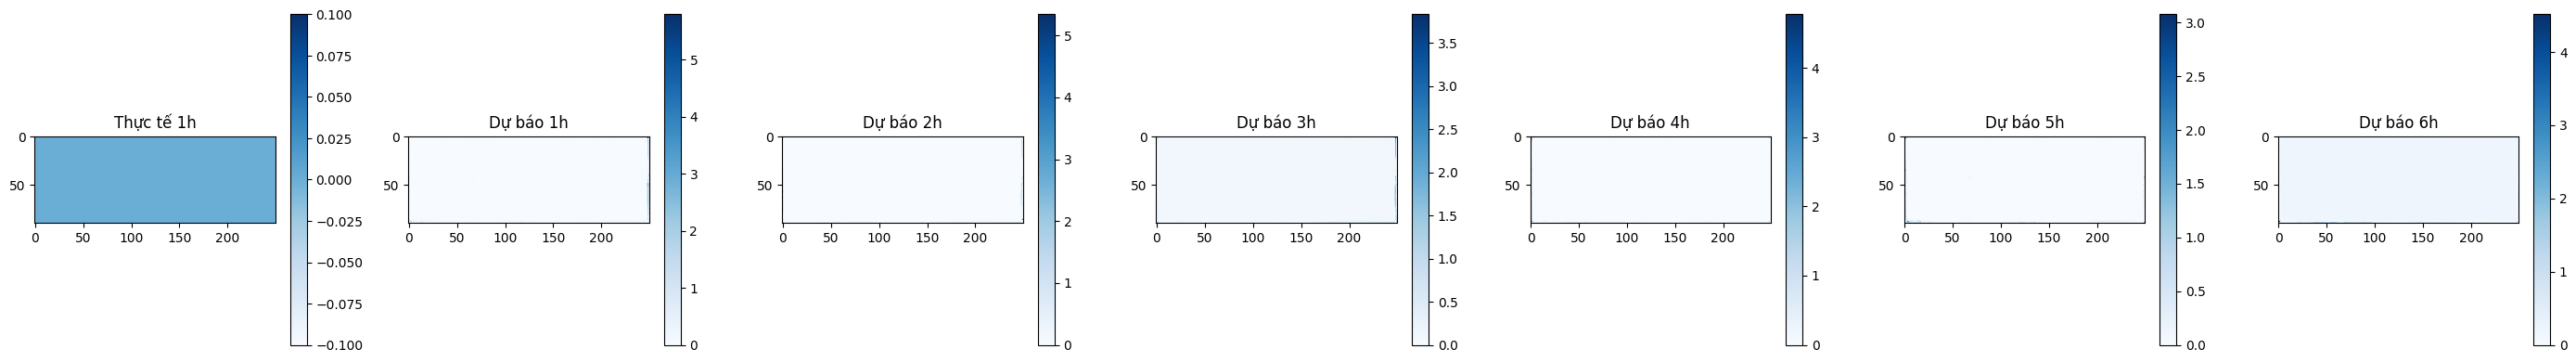

Hoàn thành dự báo với U-Net (BO-tuned)!


In [21]:
# Chọn sample cuối sau reshape
test_sample_u = X_val_u[-1:]     # (1, H, W, channels)
y_true_sample = y_val[-1:]       # (1, H, W, n_horizons)

# Sinh dự báo với model BO-tuned
preds_bo = make_predictions(best_model, test_sample_u, radar_params)
# preds_bo.shape == (1, H, W, n_horizons)

# Vẽ so sánh
visualize_predictions(
    original=y_true_sample,
    preds=preds_bo,
    horizons=horizons,
    timestep=0
)
# Lưu model
best_model.save("unet_multi_horizon_bo.h5")
print("Hoàn thành dự báo với U-Net (BO-tuned)!")
